# Подготовка данных

In [3]:
#pip install transformers tokenizers pandas seaborn torch numpy scikit-learn torcheval wandb fasttext

In [5]:
import json
import pandas as pd
import numpy as np
import re
import seaborn as sns
from pathlib import Path
import torch

from sklearn.preprocessing import LabelEncoder
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [6]:
with open("dftrain.jsonl", "r") as f:
    df_train = pd.DataFrame.from_records(map(lambda l: json.loads(l.strip()), f))

with open("dftest.jsonl", "r") as f:
    df_test = pd.DataFrame.from_records(map(lambda l: json.loads(l.strip()), f))

In [7]:
# ФАЙЛ ДЛЯ ПРОГОНКИ НА ПОЛНОМ ДАТАСЕТЕ
# with open("dftrain_full.jsonl", "r") as f:
#     df_train = pd.DataFrame.from_records(map(lambda l: json.loads(l.strip()), f))

# with open("dftest_full.jsonl", "r") as f:
#     df_test = pd.DataFrame.from_records(map(lambda l: json.loads(l.strip()), f))

Сделаем необходимые для обучения переменные.

**Кол-во классов**

In [8]:
label_encoder = LabelEncoder().fit(df_train["topic_le"])
df_train["topic_le2"] = label_encoder.transform(df_train["topic_le"])
df_test["topic_le2"] = label_encoder.transform(df_test["topic_le"])

In [9]:
num_classes = len(label_encoder.classes_)
num_classes

22

**Веса классов**

In [10]:
weights_train = torch.from_numpy(df_train['topic_le2'].value_counts(normalize=True).sort_index().values.astype(np.float32))
weights_test = torch.from_numpy(df_test['topic_le2'].value_counts(normalize=True).sort_index().values.astype(np.float32))

**Соответствие номера класса с названием класса** 

In [11]:
dict_topic = dict(zip(df_train.topic, df_train.topic_le2))
dict_topic = dict(sorted(dict_topic.items(), key=lambda item: item[1]))

## Предобработка данных

Сделаем нужную обработку текстов:
 - приведем к нижнему регистру
 - уберем спец. символы и лишние пробелы

In [12]:
def text_prepocessing(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^0-9a-zA-Zа-яА-ЯёЁ]", " ", text)
    text = re.sub(r"\s+", " ", text)    
    return text

In [13]:
df_test['text_preproc'] = df_test.text.apply(text_prepocessing)
df_train['text_preproc'] = df_train.text.apply(text_prepocessing)

## Токенизация

Будем исп-ть BPE (byte pair encoding) токенизацию.

In [14]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer


tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[PAD]", "[MASK]"])

In [15]:
# обучение
tokenizer.train_from_iterator(df_train["text_preproc"], trainer=trainer)

In [16]:
# сохранили в файл
tokenizer.save("tokenizer.json")

In [17]:
# посмотрим на размер словаря
tokenizer.get_vocab_size()

30000

In [32]:
train_path, test_path = Path("dftrain_dl.jsonl"), Path("dftest_dl.jsonl")
if train_path.exists():
    train_path.unlink()
if test_path.exists():
    test_path.unlink()

with open('dftrain_dl.jsonl', "a", encoding="utf-8") as f:
    for sample in df_train.sample(len(df_train), random_state=123)[['text_preproc', 'topic_le2']].to_dict(orient="records"):
        f.write(json.dumps(sample, ensure_ascii=False) + "\n")

with open('dftest_dl.jsonl', "a", encoding="utf-8") as f:
    for sample in df_test[['text_preproc', 'topic_le2']].to_dict(orient="records"):
        f.write(json.dumps(sample, ensure_ascii=False) + "\n")

Посмотрим на длину последоватеьностей

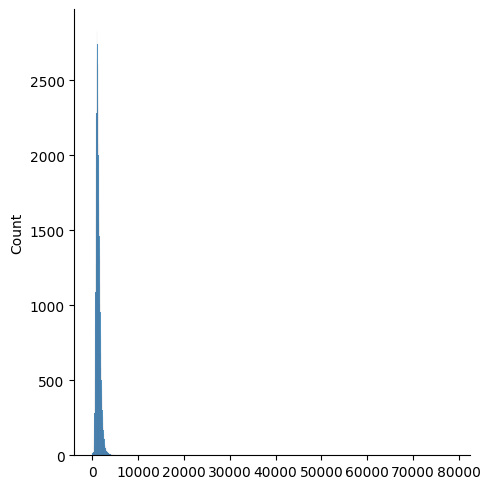

In [16]:
_ = sns.displot([len(sent) for sent in df_test['text_preproc']])

Можно заметить, что в датасете присутствуют очень длинные тексты. Однако бОльшая их часть до 5000 слов в тексте. Поэтому при обучении моделей будем обрезать тексты до 5000 слов.

## Датасет

Обрадотка датасета будем исп-ть Iterable Dataset? который работает следующим образом:
1. Получаем на вход json файл для Tokenizer
2. Будем читать по одной строчке
3. Во время чтения строки вызываем tokernizer.encode(line).ids
4. Будем возвращать словарь с ключами text: line.ids, label: label

In [18]:
from torch.utils.data import Dataset, IterableDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.metrics import classification_report

from collections import defaultdict
from collections.abc import Iterable
from functools import partial
from pathlib import Path
from typing import Any

In [19]:
BATCH_SIZE = 64
MAX_LENGTH = 5000

In [20]:
class MyIterableDataset(IterableDataset):
    def __init__(self, tokenizer_path: Path, dataset_path: Path, max_length: int) -> None:
        self.dataset_path = dataset_path
        self.max_length = max_length
        self.tokenizer = Tokenizer.from_file(str(tokenizer_path))

    def __iter__(self) -> Iterable[dict[str, Any]]:
        with self.dataset_path.open("r", encoding="utf-8") as file:
            counter = 0
            for line in map(lambda x: json.loads(x.strip()), file):
                ids = self.tokenizer.encode(line["text_preproc"]).ids[:self.max_length]
                yield {"text": ids, "topic_le": line["topic_le2"]}

In [21]:
def collate_fn(samples: list[dict[str, Any]]) -> dict[str, torch.Tensor]:
    tensor_dict = defaultdict(list)
    for sample in samples:
        for key, value in sample.items():
            tensor_dict[key].append(value)
    
    # Pad values
    out = {
        "text": pad_sequence([torch.tensor(t) for t in tensor_dict["text"]], batch_first=True),
        "topic_le": torch.tensor(tensor_dict["topic_le"]),
    }
    return out

In [22]:
train_set = MyIterableDataset(Path('tokenizer.json'), Path('dftrain_dl.jsonl'), MAX_LENGTH)
test_set = MyIterableDataset(Path('tokenizer.json'), Path('dftest_dl.jsonl'), MAX_LENGTH)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=1, pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=1, pin_memory=True, collate_fn=collate_fn)

In [23]:
# проверим на корректность
next(iter(train_loader))

{'text': tensor([[  611,   412,  7396,  ...,     0,     0,     0],
         [ 7758,  6106,  3574,  ...,     0,     0,     0],
         [ 5877,  1366,  1241,  ...,     0,     0,     0],
         ...,
         [ 8134, 14092,   508,  ...,     0,     0,     0],
         [   86,  2021,  2950,  ...,     0,     0,     0],
         [ 5069, 12174,   115,  ...,     0,     0,     0]]),
 'topic_le': tensor([11, 16, 11, 16,  2,  2, 13, 16, 18, 13, 16, 11, 21,  9, 13,  6, 17,  2,
         18,  6, 13,  9, 18, 16, 11, 11, 20, 16,  1,  2, 16, 18, 21, 11,  6,  2,
         19, 13, 16,  2, 13,  2, 11, 13, 16,  2, 11, 16, 11,  9, 11, 21, 11, 11,
          6,  2, 11, 11, 14, 19,  5, 21, 11,  9])}

# Модели

## LSTM

Для начала начнем с чего то простого и попробуем для задачи классификации текстов обучить LSTM. Обучать все слои будем с нуля (из случайной инициализации). Также поэкспериментируем с архитектурой модели и гиперпараметрами.

Также будем логировать метрики в [wandb](https://wandb.ai/sofibuz/HSE_MLDS_Project_year1). Для более ясной картины будем смотреть на accyracy, f1 macro, f1 weighted, accyracy top3, f1 по каждому классу в отдельности.

_Примечание:_ accuracy top3 поможет понять, как сильно ошибается модель. Ранее стояла проблема предсказывания малочисоенных классов. Есть гипотеза, что возможно из вер-ти стоят на втоорой или третьем месте по величине. Т.е. модель все таки улавливает класс, однако он не на первом месте.

In [24]:
import wandb
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_metrics, valid_metrics):
    clear_output()
    fig, axs = plt.subplots(3, 2, figsize=(13, 4))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')

    for (ax1, ax2), train_m_name, valid_m_name in zip(((0, 1), (1, 0), (1, 1), (2, 0), (2, 1)), train_metrics, valid_metrics):
        train_m, valid_m = train_metrics[train_m_name], valid_metrics[valid_m_name]
        axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
        axs[ax1][ax2].plot(range(1, len(valid_m) + 1), valid_m, label='test')
        axs[ax1][ax2].set_ylabel(train_m_name)

    for ax1 in axs:
        for ax2 in ax1:
            ax2.set_xlabel('epoch')
            ax2.legend()

    plt.show()

In [27]:
class LSTMClassifier(torch.nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        num_classes: int,
        embed_dim: int = 256,
        hidden_size: int = 128,
        linear_size: int = 128,
        bidirectional: bool = False,
        dropout_prob: float = 0.1,
        num_layers: int = 1,
    ) -> None:
        super().__init__()
        self._embedding = torch.nn.Embedding(
            num_embeddings=tokenizer.get_vocab_size(),
            embedding_dim=embed_dim,
            padding_idx=tokenizer.get_vocab()["[PAD]"],
        )
        self._lstm = torch.nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
        )
        self._linear = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(hidden_size * 2 if bidirectional else hidden_size, linear_size),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(linear_size, num_classes),
        )

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        batch_size = tokens.size(0)
        embeds = self._embedding(tokens)
        lengths = (tokens != 0).sum(dim=-1).cpu()
        packed = pack_padded_sequence(embeds, lengths=lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (h, c) = self._lstm(packed)
        output, _ = pad_packed_sequence(lstm_out, batch_first=True)
        output = torch.max(output, dim=1).values
        logits = self._linear(output)
        return logits

In [28]:
LSTMClassifier(tokenizer, num_classes=num_classes)(next(iter(train_loader))["text"]).size()

torch.Size([64, 22])

In [26]:
def accuracy_top_k(logits, labels, k=1):
    batch_size = logits.size(0)
    out = torch.topk(logits, k=k, dim=-1).indices
    top3 = (out.view(batch_size, 1, -1) == labels.view(batch_size, -1, 1)).float().sum() / batch_size
    return top3

def f1_weighted(logits, labels, weights):
    list_f1 = multiclass_f1_score(logits, labels, average=None, num_classes=logits.size(-1))
    return torch.sum(list_f1 * weights)


@torch.no_grad()
def get_predictions(model, valid_loader, class_report=False, dict_topic=None):
    predictions = defaultdict(list)
    model.eval()
    for batch in tqdm(valid_loader):
        text = batch["text"].to(device)
        labels = batch["topic_le"]

        logits = model(text)
        y = logits.argmax(dim=-1).cpu().numpy()
        predictions['y_pred'].append(y)
        predictions['y_true'].append(labels.numpy())

    y_pred = np.concatenate(predictions['y_pred'], axis=0)
    y_true = np.concatenate(predictions['y_true'], axis=0)
    if class_report == True:
        print(classification_report(y_true, y_pred, target_names=dict_topic))
        
    return y_pred, y_true

In [27]:
def training_epoch(model, optimizer, criterion, train_loader, weights, tqdm_desc):
    num_batches = 0
    train_loss = 0
    metrics = defaultdict(float)
    model.train()
    for batch in tqdm(train_loader, desc=tqdm_desc):
        text = batch["text"].to(device)
        labels = batch["topic_le"].to(device)

        optimizer.zero_grad()
        logits = model(text)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        for m_name, m in {
            "accuracy": lambda logits, labels: (logits.argmax(dim=-1) == labels).float().mean(),
            "accuracy top3": partial(accuracy_top_k, k=3),
            "f1 micro": partial(multiclass_f1_score, average="micro", num_classes=logits.size(-1)),
            "f1 macro": partial(multiclass_f1_score, average="macro", num_classes=logits.size(-1)),
            "f1 class": partial(multiclass_f1_score, average=None, num_classes=logits.size(-1)),
            "f1 weighted": partial(f1_weighted, weights=weights)
        }.items():
            metrics[m_name] += m(logits, labels)
        num_batches += 1
        if num_batches % 100 == 0:
            wandb.log({
                "batch train loss": train_loss / num_batches,
                **{f"batch train {k}": v / num_batches for k, v in metrics.items()},
            })

    train_loss /= num_batches
    for m_name in metrics:
        metrics[m_name] /= num_batches
    return train_loss, metrics


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, weights, tqdm_desc):
    num_batches = 0
    valid_loss = 0
    metrics = defaultdict(float)
    model.eval()
    for batch in tqdm(valid_loader, desc=tqdm_desc):
        text = batch["text"].to(device)
        labels = batch["topic_le"].to(device)

        logits = model(text)
        loss = criterion(logits, labels)

        valid_loss += loss.item()
        for m_name, m in {
            "accuracy": lambda logits, labels: (logits.argmax(dim=-1) == labels).float().mean(),
            "accuracy top3": partial(accuracy_top_k, k=3),
            "f1 micro": partial(multiclass_f1_score, average="micro", num_classes=logits.size(-1)),
            "f1 macro": partial(multiclass_f1_score, average="macro", num_classes=logits.size(-1)),
            "f1 class": partial(multiclass_f1_score, average=None, num_classes=logits.size(-1)),
            "f1 weighted": partial(f1_weighted, weights=weights),
        }.items():
            metrics[m_name] += m(logits, labels)
        num_batches += 1

    valid_loss /= num_batches
    for m_name in metrics:
        metrics[m_name] /= num_batches
    return valid_loss, metrics


def train(model, optimizer, scheduler, criterion,
          train_loader, valid_loader,
          num_epochs, weights_train, weights_valid, name,
          early_stop_thresh):
    wandb.init(project="HSE_MLDS_Project_year1", name=name)
    wandb.watch(model)
    
    best_f1_weighted, best_epoch = -1, -1
    train_losses, valid_losses = [], []
    train_metrics, valid_metrics = defaultdict(list), defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        train_loss, train_metric = training_epoch(
            model, optimizer, criterion, train_loader, weights_train,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss, valid_metric = validation_epoch(
            model, criterion, valid_loader, weights_valid,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )
        
        # логирование
        wandb.log({
            "train loss": train_loss, "test loss": valid_loss,
            **{f"train f1 for class {idx}": v.item() for idx, v in enumerate(train_metric.pop("f1 class", []))},
            **{f"test f1 for class {idx}": v.item() for idx, v in enumerate(valid_metric.pop("f1 class", []))},
            **{f"train {k}": v.item() for k, v in train_metric.items()},
            **{f"test {k}": v.item() for k, v in valid_metric.items()},
            "epoch": epoch, 
            "lr": scheduler.get_last_lr()[0] if scheduler is not None else optimizer.param_groups[-1]['lr']
        })

        if scheduler is not None:
            scheduler.step()

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        for m_name, m_value in train_metric.items():
            train_metrics[m_name].append(m_value.item())
        for m_name, m_value in valid_metric.items():
            valid_metrics[m_name].append(m_value.item())
        plot_losses(train_losses, valid_losses, train_metrics, valid_metrics)
        
        # early stopping
        if valid_metric['f1 weighted'] > best_f1_weighted:
            best_f1_weighted = valid_metric['f1 weighted']
            best_epoch = epoch
        elif epoch - best_epoch > early_stop_thresh:
            print("Early stopped training at epoch %d" % epoch)
            break
        
    wandb.finish() 
    return train_losses, valid_losses, train_metrics, valid_metrics

In [43]:
NUM_EPOCHS = 100

model = LSTMClassifier(
    tokenizer, num_classes,
    embed_dim=256, hidden_size=128, linear_size=128,
    bidirectional=True, dropout_prob=0.4,
).to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = torch.nn.CrossEntropyLoss()

In [44]:
# число параметров
sum(param.numel() for param in model.parameters())

8110998

Один из запуском представлен ниже. Другие запуски были на разных архитектурах, с разными гиперами. Однако про каждый запуск подробно описывать не будем.

_Примечание:_ другие запуски можно найти в [wandb](https://wandb.ai/sofibuz/HSE_MLDS_Project_year1).

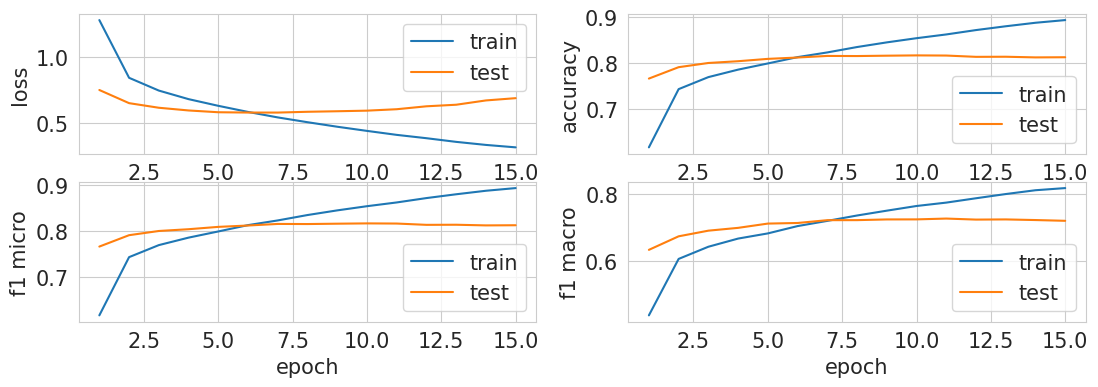

Training 16/100: 0it [00:00, ?it/s]

In [ ]:
train_losses, valid_losses, train_metrics, valid_metrics = train(
    model, optimizer, None, criterion, train_loader, test_loader,
    NUM_EPOCHS, weights_train.to(device), weights_test.to(device),
    name='LSTM--bidirectional-lstm1-v04',
)

## LSTM + FastText

Попробуем также взять предобученные эмбединги слов. Будем исп-ть эмбединги из fasttext. Дообучать их не будем.

In [33]:
import fasttext.util

In [34]:
fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

Также придется переписать датасет и загрузить весь датасет в память (а не счтывать с жиска как было ранее).

In [35]:
class MyDatasetFastText(Dataset):
    def __init__(self, dataset_path: Path, max_length: int) -> None:
        self.max_length = max_length
        with open(dataset_path, "r") as f:
            self.df = pd.DataFrame.from_records(map(lambda l: json.loads(l.strip()), f))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        line = self.df.iloc[item]
        return {
            "text": np.vstack(
                [ft.get_word_vector(word).astype(np.float32) for word in line["text_preproc"].split()[:self.max_length]]
            ),
            "topic_le": line["topic_le2"],
        }

In [36]:
train_set = MyDatasetFastText(Path('dftrain_dl.jsonl'), MAX_LENGTH)
test_set = MyDatasetFastText(Path('dftest_dl.jsonl'), MAX_LENGTH)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=4, shuffle=True,
                          pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, collate_fn=collate_fn)

In [37]:
class LSTMClassifierFastText(torch.nn.Module):
    def __init__(
        self,
        embed_dim,
        num_classes: int,
        hidden_size: int = 128,
        linear_size: int = 128,
        bidirectional: bool = False,
        dropout_prob: float = 0.1,
        num_layers: int = 1,
    ) -> None:
        super().__init__()
        self._lstm = torch.nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
        )
        self._linear = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(hidden_size * 2 if bidirectional else hidden_size, linear_size),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(linear_size, num_classes),
        )

    def forward(self, embeds: torch.Tensor) -> torch.Tensor:
        batch_size = embeds.size(0)
        lengths = (embeds.sum(-1) != 0).sum(dim=-1).cpu()
        packed = pack_padded_sequence(embeds, lengths=lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (h, c) = self._lstm(packed)
        output, _ = pad_packed_sequence(lstm_out, batch_first=True)
        output = torch.max(output, dim=1).values
        logits = self._linear(output)
        return logits

In [38]:
LSTMClassifierFastText(embed_dim=ft.get_dimension(), num_classes=num_classes)(next(iter(train_loader))["text"]).size()

torch.Size([64, 22])

In [39]:
NUM_EPOCHS = 100

model = LSTMClassifierFastText(
    ft.get_dimension(), num_classes,
    bidirectional=True, dropout_prob=0.3,
).to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = torch.nn.CrossEntropyLoss()

Можно заметить, что число параметров очень сильно уменьшилось, когда отпала необходимость обучать эмбединги.

In [40]:
# число параметров
sum(param.numel() for param in model.parameters())

476054

Далее представлены некоторые их запусков. Другие эксперименты можно найти в [wandb](https://wandb.ai/sofibuz/HSE_MLDS_Project_year1).

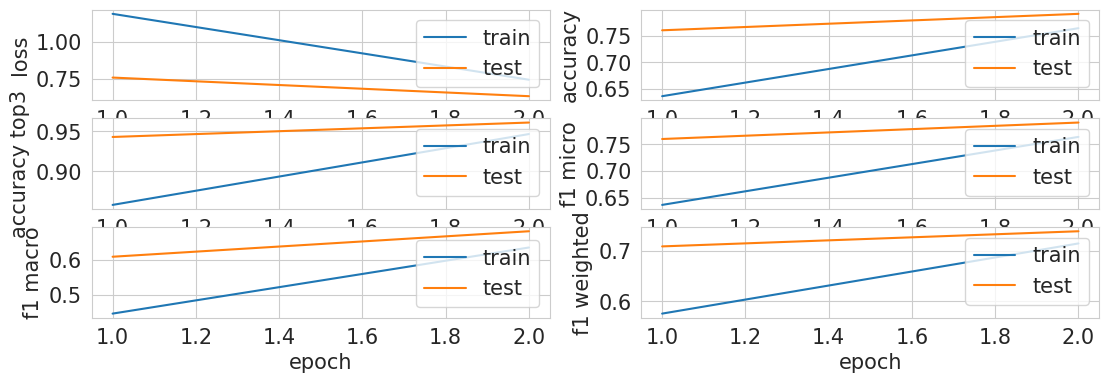

Training 3/100:   0%|          | 0/3243 [00:00<?, ?it/s]

In [52]:
train_losses, valid_losses, train_metrics, valid_metrics = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader,
    NUM_EPOCHS, weights_train.to(device), weights_test.to(device),
    name='LSTM--fasttext-v04', early_stop_thresh=5,
)

In [54]:
get_predictions(model, test_loader, class_report=True, dict_topic=dict_topic)

  0%|          | 0/649 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

   69-я параллель       0.78      0.46      0.58       121
           Бизнес       0.58      0.44      0.50       267
      Бывший СССР       0.86      0.88      0.87      3376
              Дом       0.82      0.78      0.80       797
    Забота о себе       0.65      0.68      0.66       114
         Из жизни       0.85      0.58      0.69      1613
   Интернет и СМИ       0.81      0.71      0.75      2333
             Крым       1.00      0.04      0.08        24
    Культпросвет        0.17      0.08      0.11        12
         Культура       0.81      0.94      0.87      2584
          Легпром       0.00      0.00      0.00         4
              Мир       0.83      0.86      0.84      7048
       Моя страна       0.77      0.73      0.75       221
  Наука и техника       0.90      0.80      0.85      2722
       Нацпроекты       0.87      0.94      0.90       170
      Путешествия       0.81      0.88      0.84       

/home/src/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/src/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/src/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([16, 11, 18, ..., 21,  6, 16]), array([16, 11, 18, ..., 21,  6, 17]))

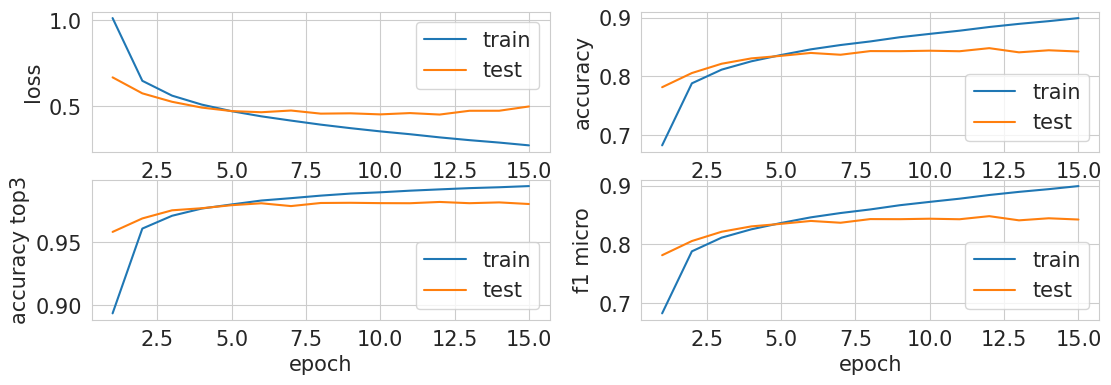

Training 16/100:   0%|          | 0/3243 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
train_losses, valid_losses, train_metrics, valid_metrics = train(
    model, optimizer, None, criterion, train_loader, test_loader,
    NUM_EPOCHS, weights_train.to(device), weights_test.to(device),
    name='LSTM--fasttext-v03', early_stop_thresh=5,
)

In [46]:
get_predictions(model, test_loader, class_report=True, dict_topic=dict_topic)

  0%|          | 0/649 [00:00<?, ?it/s]

                   precision    recall  f1-score   support

   69-я параллель       0.71      0.55      0.62       121
           Бизнес       0.57      0.61      0.59       267
      Бывший СССР       0.84      0.91      0.87      3376
              Дом       0.86      0.73      0.79       797
    Забота о себе       0.67      0.77      0.72       114
         Из жизни       0.76      0.69      0.72      1613
   Интернет и СМИ       0.78      0.77      0.77      2333
             Крым       0.50      0.17      0.25        24
    Культпросвет        0.00      0.00      0.00        12
         Культура       0.89      0.89      0.89      2584
          Легпром       0.00      0.00      0.00         4
              Мир       0.84      0.84      0.84      7048
       Моя страна       0.69      0.81      0.75       221
  Наука и техника       0.83      0.87      0.85      2722
       Нацпроекты       0.95      0.91      0.93       170
      Путешествия       0.79      0.89      0.84       

/home/src/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/src/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/src/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([16, 11, 18, ..., 21,  6, 17]), array([16, 11, 18, ..., 21,  6, 17]))

**Выводы по экспериментам с моделями**:
 - LSTM не очень подошла для задачи классификации текстов на данном датасете. Качество даже хуже, что на логистической регрессии. Маленькие классы так и не предсказываются хорошо. Видимо для LSTM требуется больше текстов к маленьких классах. При обучении модель на всем датасете, где соответственно было больше текстов по маленьким классам, они предсказыались гораздо лучше (однако все равно на фоне общего качество - плохо)
 - Разница в качестве между модель, обученной на 200к текстов, и моделью, обученной на 1 млн текстов, не очень большая (от 1% до 5% в зависимости от метрик качества).
 - LSTM с FastFext работает немного лучше, чем с непедобученными эмбедингами
 - LSTM с 2мя слоями работает гораздо хуже, чем с один
 - Модель склонная к переобучению (с любой архитектурой). Для уменьшения переобучения приходилось исп-ть разные хаки. Модель с FastText переобучалась гораздо меньше.
 - Много эпох для обучения было не нужно. Довольно быстро модель выходила на плато по метрикам
 - Модель относитеьно быстро обучается. По времени обучения гораздо быстрее берт